# Online Retail Decommendation System.

In [2]:
# Import necessary libraries.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Read data source CSV file.
file_path = 'OnlineRetail.csv'  
df = pd.read_csv(file_path, encoding='unicode_escape')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
# Check dataframe information.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Preprocessing

In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
# Drop rows with missing CustomerID as they may not be useful for recommendations
df.dropna(subset=['CustomerID'], inplace=True)

In [10]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Exploratory Data Analysis (EDA)

In [12]:
country_summary = df.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)

print("Number of Transactions by Country:\n", country_summary)

Number of Transactions by Country:
 Country
United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                       

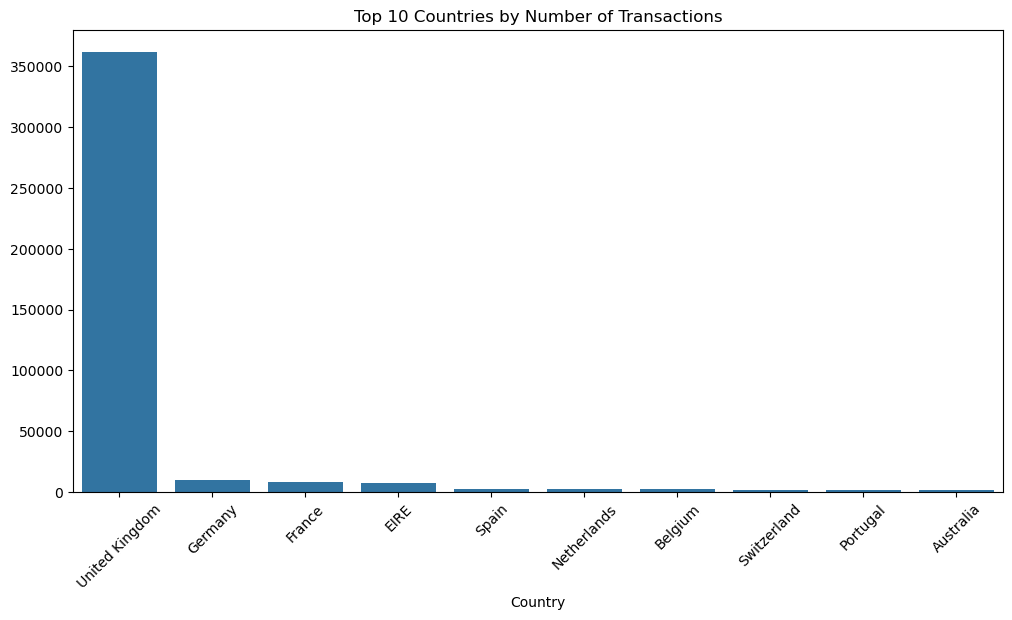

In [13]:
# Plot top 10 transactions by country
plt.figure(figsize=(12, 6))
sns.barplot(x=country_summary.index[:10], y=country_summary.values[:10])
plt.title('Top 10 Countries by Number of Transactions')
plt.xticks(rotation=45)
plt.show()

In [14]:
# Summary of sales over time
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Quantity'].sum()
print(monthly_sales)

Month
2010-12    296362
2011-01    269379
2011-02    262833
2011-03    344012
2011-04    278585
2011-05    367852
2011-06    356922
2011-07    363418
2011-08    386612
2011-09    537496
2011-10    569666
2011-11    669915
2011-12    203836
Freq: M, Name: Quantity, dtype: int64


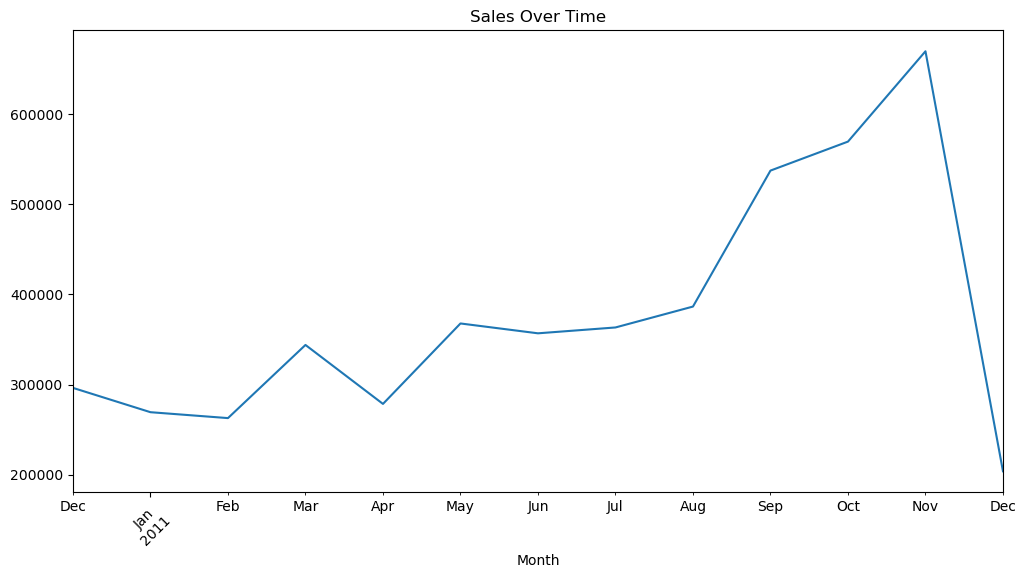

In [15]:
# Plot sales over time
plt.figure(figsize=(12, 6))
monthly_sales.plot()
plt.title('Sales Over Time')
plt.xticks(rotation=45)
plt.show()

# Top Popular Items Analysis

In [17]:
# Find the most popular items globally
global_popular_items = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False)
print("Top 10 Globally Popular Items:")
global_popular_items.head(10)

Top 10 Globally Popular Items:


Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53215
JUMBO BAG RED RETROSPOT               45066
ASSORTED COLOUR BIRD ORNAMENT         35314
WHITE HANGING HEART T-LIGHT HOLDER    34147
PACK OF 72 RETROSPOT CAKE CASES       33409
POPCORN HOLDER                        30504
RABBIT NIGHT LIGHT                    27094
MINI PAINT SET VINTAGE                25880
PACK OF 12 LONDON TISSUES             25321
PACK OF 60 PINK PAISLEY CAKE CASES    24163
Name: Quantity, dtype: int64

In [18]:
# Find the most popular items by country
country_popular_items = df.groupby(['Country', 'Description'])['Quantity'].sum().sort_values(ascending=False)
print("Top 10 Country-wise Popular Items:")
country_popular_items.groupby(level=0).head(10)

Top 10 Country-wise Popular Items:


Country         Description                       
United Kingdom  WORLD WAR 2 GLIDERS ASSTD DESIGNS     47982
                JUMBO BAG RED RETROSPOT               40880
                ASSORTED COLOUR BIRD ORNAMENT         32679
                WHITE HANGING HEART T-LIGHT HOLDER    32097
                POPCORN HOLDER                        28562
                                                      ...  
Bahrain         PINK REGENCY TEACUP AND SAUCER            6
Saudi Arabia    GLASS JAR PEACOCK BATH SALTS              6
                GLASS JAR MARMALADE                       6
                GOLD EAR MUFF HEADPHONES                  2
                GLASS JAR DAISY FRESH COTTON WOOL         1
Name: Quantity, Length: 369, dtype: int64

# Recommendation System Function

In [20]:
# Find the most popular items by month
month_popular_items = df.groupby(['Month', 'Description'])['Quantity'].sum().sort_values(ascending=False)
print("Top 10 Month-wise Popular Items:")
month_popular_items.groupby(level=0).head(10)

Top 10 Month-wise Popular Items:


Month    Description                      
2011-11  ASSTD DESIGN 3D PAPER STICKERS       12551
         RABBIT NIGHT LIGHT                   12322
2011-04  WORLD WAR 2 GLIDERS ASSTD DESIGNS    10128
2011-10  WORLD WAR 2 GLIDERS ASSTD DESIGNS     8174
2011-11  POPCORN HOLDER                        8157
                                              ...  
2011-12  DISCO BALL CHRISTMAS DECORATION       1446
         PAPER CHAIN KIT 50'S CHRISTMAS        1393
         WORLD WAR 2 GLIDERS ASSTD DESIGNS     1363
         ASSORTED COLOUR BIRD ORNAMENT         1274
         RAIN PONCHO RETROSPOT                 1236
Name: Quantity, Length: 130, dtype: int64

In [21]:
def recommendations(global_items, country_items, month_items, country=None, month=None):
    
    """
    Recommends top items based on global, country, or month data.

    Parameters:
    - global_items: Top global items
    - country_items: Top items for a specific country
    - month_items: Top items for a specific month
    - country: Filter recommendations by country (optional)
    - month: Filter recommendations by month (optional)

    Returns:
    - Top recommended items
    """
    
    
    if country and month:
        return month_items.loc[(month, country)]
    elif country:
        return country_items.loc[country]
    elif month:
        return month_items.loc[month]
    else:
        return global_items.head(10)

# Example Usage for the System

In [23]:
country = 'United Kingdom'
month = '2011-12'

In [24]:
print("Global Recommendations:\n", recommendations(global_popular_items, country_popular_items, month_popular_items))

Global Recommendations:
 Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53215
JUMBO BAG RED RETROSPOT               45066
ASSORTED COLOUR BIRD ORNAMENT         35314
WHITE HANGING HEART T-LIGHT HOLDER    34147
PACK OF 72 RETROSPOT CAKE CASES       33409
POPCORN HOLDER                        30504
RABBIT NIGHT LIGHT                    27094
MINI PAINT SET VINTAGE                25880
PACK OF 12 LONDON TISSUES             25321
PACK OF 60 PINK PAISLEY CAKE CASES    24163
Name: Quantity, dtype: int64


In [25]:
print(f"\nRecommendations for {country}:")
recommendations(global_popular_items, country_popular_items, month_popular_items, country=country)


Recommendations for United Kingdom:


Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS      47982
JUMBO BAG RED RETROSPOT                40880
ASSORTED COLOUR BIRD ORNAMENT          32679
WHITE HANGING HEART T-LIGHT HOLDER     32097
POPCORN HOLDER                         28562
                                       ...  
CRUK Commission                          -16
POSTAGE                                  -21
ASSORTED TUTTI FRUTTI ROUND BOX          -24
Discount                               -1191
ROTATING SILVER ANGELS T-LIGHT HLDR    -1853
Name: Quantity, Length: 3849, dtype: int64

In [26]:
print(f"\nRecommendations for {month}:")
recommendations(global_popular_items, country_popular_items, month_popular_items, month=month)


Recommendations for 2011-12:


Description
POPCORN HOLDER                       5343
RABBIT NIGHT LIGHT                   3678
VINTAGE DOILY JUMBO BAG RED          2066
BLACK RECORD COVER FRAME             1464
METAL SIGN TAKE IT OR LEAVE IT       1451
                                     ... 
SET OF 6 HALLOWEEN GHOST T-LIGHTS     -36
PARTY CONES CANDY ASSORTED            -42
ASSORTED TUTTI FRUTTI PEN             -59
MAGIC DRAWING SLATE PURDEY            -62
OFFICE MUG WARMER PINK               -221
Name: Quantity, Length: 2189, dtype: int64